In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn import linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# 1. Load Data

In [2]:
df = pd.read_csv('all_seasons.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9561 entries, 0 to 9560
Data columns (total 22 columns):
Unnamed: 0           9561 non-null int64
player_name          9561 non-null object
team_abbreviation    9561 non-null object
age                  9561 non-null float64
player_height        9561 non-null float64
player_weight        9561 non-null float64
college              9561 non-null object
country              9561 non-null object
draft_year           9561 non-null object
draft_round          9561 non-null object
draft_number         9561 non-null object
gp                   9561 non-null int64
pts                  9561 non-null float64
reb                  9561 non-null float64
ast                  9561 non-null float64
net_rating           9561 non-null float64
oreb_pct             9561 non-null float64
dreb_pct             9561 non-null float64
usg_pct              9561 non-null float64
ts_pct               9561 non-null float64
ast_pct              9561 non-null float64
s

In [3]:
# cek null
df.isnull().sum()

Unnamed: 0           0
player_name          0
team_abbreviation    0
age                  0
player_height        0
player_weight        0
college              0
country              0
draft_year           0
draft_round          0
draft_number         0
gp                   0
pts                  0
reb                  0
ast                  0
net_rating           0
oreb_pct             0
dreb_pct             0
usg_pct              0
ts_pct               0
ast_pct              0
season               0
dtype: int64

In [4]:
df.head(3)

,Unnamed: 0,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,...,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
0,0,Chris Robinson,VAN,23.0,195.58,90.71840,Western Kentucky,USA,1996,2,...,4.6,1.7,1.6,-11.4,0.039,0.088,0.155,0.486,0.156,1996-97
1,1,Matt Fish,MIA,27.0,210.82,106.59412,North Carolina-Wilmington,USA,1992,2,...,0.3,0.8,0.0,-15.1,0.143,0.267,0.265,0.333,0.000,1996-97
2,2,Matt Bullard,HOU,30.0,208.28,106.59412,Iowa,USA,Undrafted,Undrafted,...,4.5,1.6,0.9,0.9,0.016,0.115,0.151,0.535,0.099,1996-97


# 2. Rules of Requirements
- age <= 25
- player_height >= 180
- player_weight <= 90
- pts >= 6
- reb >= 3



In [5]:
# Labelling by Rules
dfx = df.copy()
dfx['target'] = list(map(lambda age, height, weight, pts, reb: True if (age <= 25) and (height >= 180) and (weight <= 90)  and (pts >= 6) and (reb >= 3) else False, dfx['age'],dfx['player_height'],dfx['player_weight'],dfx['pts'], dfx['reb']))

# cek hasil
dfx[['age','player_height','player_weight','pts','reb', 'target']].tail(10)

,age,player_height,player_weight,pts,reb,target
9551,30.0,208.28,106.59412,13.1,5.9,False
9552,28.0,193.04,97.52228,16.2,2.7,False
9553,27.0,185.42,92.98636,21.1,4.8,False
9554,25.0,210.82,111.13004,14.3,6.7,False
9555,21.0,195.58,90.71840,11.0,3.2,False
9556,29.0,200.66,97.52228,1.5,3.0,False
9557,23.0,193.04,83.91452,12.8,4.7,True
9558,25.0,220.98,120.20188,4.0,5.5,False
9559,23.0,210.82,108.86208,8.2,7.0,False
9560,30.0,203.20,102.05820,15.7,6.5,False


In [6]:
dfx.groupby('target').count()['player_name']

target
False    9370
True      191
Name: player_name, dtype: int64

# 3. Standarisasi

In [7]:
standardize = StandardScaler()
standardize.fit(dfx[['age','player_height','player_weight','pts','reb']])

dfx_standar = standardize.transform(dfx[['age','player_height','player_weight','pts','reb']])
dfx_standar = pd.DataFrame(dfx_standar, columns= ['age','player_height','player_weight','pts','reb'])
dfx_standar['target'] = dfx['target']
dfx_standar



,age,player_height,player_weight,pts,reb,target
0,-0.996742,-0.578993,-0.802604,-0.589390,-0.747850,False
1,-0.077272,1.063130,0.439607,-1.319614,-1.108712,False
2,0.612331,0.789443,0.439607,-0.606372,-0.787946,False
3,0.382463,1.063130,0.794524,-0.045967,0.334735,False
4,-1.226609,0.515755,0.439607,-0.742228,-0.787946,False
...,...,...,...,...,...,...
9556,0.382463,-0.031619,-0.270228,-1.115831,-0.226605,False
9557,-0.996742,-0.852680,-1.334980,0.803131,0.455022,True
9558,-0.537007,2.157878,1.504359,-0.691282,0.775788,False
9559,-0.996742,1.063130,0.617065,0.021961,1.377224,False


# 4.  Dataset Splitting

In [8]:
X = dfx_standar.iloc[:, :-1]
y = dfx_standar[['target']]

x_tr, x_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.18, random_state=42)
print("train\t\t" , "test")
print(x_tr.shape, "\t", x_ts.shape)
print(y_tr.shape, "\t", y_ts.shape)

train		 test
(7840, 5) 	 (1721, 5)
(7840, 1) 	 (1721, 1)


# 5. Classification 3 metode
## 1. Logistic Regression

In [59]:
# 1. Logistic Regression
LGmodel = linear_model.LogisticRegression(solver='lbfgs')
LGmodel

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## 1.2 Checking using cross validation

In [60]:
# checking using cross validation

from sklearn.utils.validation import column_or_1d
y_tr_y = column_or_1d(y_tr, warn=False)

validation1 = cross_val_score(
    LGmodel, 
    x_tr,
    y_tr_y,
    cv=5, # K-Fold 5 folding
    scoring='accuracy'
)
print(validation1)
print(validation1.mean())

[0.9815051  0.98278061 0.98469388 0.98469388 0.98405612]
0.983545918367347


## 1.3 Logistic Regression Hyperparameter Tuning

In [61]:
# LG tuning
# Params definition
solver_ = ['lbfgs', 'liblinear', 'sag', 'saga', 'newton-cg'] 
penalty_ = ['l1', 'l2', 'elasticnet', 'none']
max_iter_ = [1, 10, 100, 1000, 10000]

# buat dalam bentuk dictionary
param = {
    'penalty' : penalty_, 'solver' : solver_, 'max_iter' : max_iter_   
}
param

{'penalty': ['l1', 'l2', 'elasticnet', 'none'],
 'solver': ['lbfgs', 'liblinear', 'sag', 'saga', 'newton-cg'],
 'max_iter': [1, 10, 100, 1000, 10000]}

In [62]:
LGmodel_tunedGS = GridSearchCV(
                            LGmodel,
                            param,
                            cv = 5
                            )
LGmodel_tunedGS.fit(x_tr, y_tr)
LGmodel_tunedGS.best_params_

c:\users\nadian\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
c:\users\nadian\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\nadian\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
c:\users\nadian\appdata\local\programs\python\python37\lib\site-packages\sklearn\utils\validation.py:744: DataConversionW

{'max_iter': 10, 'penalty': 'none', 'solver': 'lbfgs'}

In [64]:
LGmodel_tunedGS.best_params_

{'max_iter': 10, 'penalty': 'none', 'solver': 'lbfgs'}

## 1.4 Best Params Application for Logistic Regression

In [75]:
LGmodel_tuned = linear_model.LogisticRegression(max_iter=10, penalty='none', solver='lbfgs')

# Rechecking 
validation1_tuned = cross_val_score(
    LGmodel_tuned, 
    x_tr,
    y_tr_y,
    cv=5, # K-Fold 5 folding
    scoring='accuracy'
)
print(validation1_tuned)
print("Sebelum dituning : ", validation1.mean())
print("Setelah dituning : ",validation1_tuned.mean())


[0.98214286 0.98341837 0.98469388 0.98469388 0.98405612]
Sebelum dituning :  0.983545918367347
Setelah dituning :  0.9838010204081632


c:\users\nadian\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\nadian\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://

In [76]:
# FITTING
LGmodel_tuned.fit(x_tr, y_tr_y)

c:\users\nadian\appdata\local\programs\python\python37\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

<hr>

<hr>

# 2. KNN Classifier

In [11]:
KNNmodel = KNeighborsClassifier()
KNNmodel

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

## 2.2 Checking using cross validation

In [14]:
validation2_ = cross_val_score(
    KNNmodel, 
    x_tr,
    y_tr_y,
    cv=5, # K-Fold 5 folding
    scoring='accuracy'
)
print(validation2_)
print(validation2_.mean())

[0.99170918 0.99043367 0.98979592 0.9942602  0.99553571]
0.9923469387755102


## 2.3 KNN Classifier Hyperparameter Tuning

In [26]:
# KNN tuning
# Params definition
n_neighbors_ = list(range(3,20,3))
weights_ = ['uniform', 'distance']
algorithm_ = ['auto', 'ball_tree', 'kd_tree', 'brute', 'auto']
p_ = [1,2]

param = {      'n_neighbors': n_neighbors_,
               'weights': weights_,
               'algorithm': algorithm_,
               'p': p_
        }
param

{'n_neighbors': [3, 6, 9, 12, 15, 18],
 'weights': ['uniform', 'distance'],
 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute', 'auto'],
 'p': [1, 2]}

In [27]:
KNNmodel_tunedGS = GridSearchCV(
                            KNNmodel,
                            param,
                            cv = 5
                            )
KNNmodel_tunedGS.fit(x_tr, y_tr)
KNNmodel_tunedGS.best_params_

c:\users\nadian\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\users\nadian\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\users\nadian\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
c:\users\nadian\appdata\local\program

{'algorithm': 'auto', 'n_neighbors': 6, 'p': 1, 'weights': 'distance'}

In [28]:
KNNmodel_tunedGS.best_params_

{'algorithm': 'auto', 'n_neighbors': 6, 'p': 1, 'weights': 'distance'}

## 2.4 Best Params Application for KNN Classifier

In [29]:
KNNmodel_tuned = KNeighborsClassifier(n_neighbors = 6, 
                                        weights ='distance', 
                                        algorithm = 'auto',
                                        p = 1,
                                       )

# Rechecking 
validation2_tuned_ = cross_val_score(
    KNNmodel_tuned, 
    x_tr,
    y_tr_y,
    cv=5, # K-Fold 5 folding
    scoring='accuracy'
)
print(validation2_tuned_)
print("KNN")
print(100*'-')
print("Sebelum dituning : ", validation2_.mean())
print("Setelah dituning : ",validation2_tuned_.mean())

[0.99234694 0.99170918 0.99107143 0.99362245 0.99617347]
KNN
----------------------------------------------------------------------------------------------------
Sebelum dituning :  0.9923469387755102
Setelah dituning :  0.9929846938775512


In [77]:
# FITTING
KNNmodel_tuned.fit(x_tr,y_tr_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6, p=1,
                     weights='distance')

<hr>

# 3. Decision Tree Classifier

In [49]:
DTmodel = DecisionTreeClassifier(criterion= 'entropy', splitter='random')
DTmodel

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='random')

## 3.2 Checking using cross validation

In [50]:
validation3 = cross_val_score(
    DTmodel, 
    x_tr,
    y_tr_y,
    cv=5, # K-Fold 5 folding
    scoring='accuracy'
)
print(validation3)
print(validation3.mean())

[0.99489796 0.99489796 0.99553571 0.99298469 0.99617347]
0.9948979591836735


## 3.3 Decision Tree Classifier Hyperparameter Tuning

In [42]:
criterion_ = ['gini', 'entropy']
splitter_ = ['best', 'random']
max_features_ = ['auto', 'sqrt', 'log2', 'none']
class_weight_ = ['balanced', 'none']
min_samples_split_=[2,3,4,5]


param = {      'criterion': criterion_,
               'splitter': splitter_,
               'max_features': max_features_,
               'class_weight': class_weight_,
                'min_samples_split' : min_samples_split_
        }
param

{'criterion': ['gini', 'entropy'],
 'splitter': ['best', 'random'],
 'max_features': ['auto', 'sqrt', 'log2', 'none'],
 'class_weight': ['balanced', 'none'],
 'min_samples_split': [2, 3, 4, 5]}

In [43]:
DTmodel_tunedGS = GridSearchCV(
                            DTmodel,
                            param,
                            cv = 5
                            )
DTmodel_tunedGS.fit(x_tr, y_tr)
DTmodel_tunedGS.best_params_

c:\users\nadian\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Invalid value for max_features. Allowed string values are "auto", "sqrt" or "log2".

  FitFailedWarning)
c:\users\nadian\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Invalid value for max_features. Allowed string values are "auto", "sqrt" or "log2".

  FitFailedWarning)
c:\users\nadian\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Invalid value

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_features': 'sqrt',
 'min_samples_split': 4,
 'splitter': 'best'}

In [51]:
DTmodel_tunedGS.best_params_

{'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_features': 'sqrt',
 'min_samples_split': 4,
 'splitter': 'best'}

## 3.4 Best Params Application for Decision Tree Classifier

In [52]:
DTmodel_tuned = DecisionTreeClassifier(class_weight = 'balanced', 
                                        criterion ='entropy', 
                                        max_features = 'sqrt',
                                        min_samples_split = 4,
                                        splitter = 'best',
                                       )

# Rechecking 
validation3_tuned = cross_val_score(
    DTmodel_tuned, 
    x_tr,
    y_tr_y,
    cv=5, # K-Fold 5 folding
    scoring='accuracy'
)
print(validation3_tuned)
print("Decision Tree")
print(100*'-')
print("Sebelum dituning : ", validation3.mean())
print("Setelah dituning : ",validation3_tuned.mean())

[1.         1.         0.99617347 0.99808673 1.        ]
Decision Tree
----------------------------------------------------------------------------------------------------
Sebelum dituning :  0.9948979591836735
Setelah dituning :  0.9988520408163264


In [78]:
# FITTING
DTmodel_tuned.fit(x_tr,y_tr_y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=4, min_weight_fraction_leaf=0.0,
                       presort='deprecated', random_state=None,
                       splitter='best')

# 6. EXPORT 3 Classifier dengan parameter terbaik

In [117]:
import pickle

with open('model_LG', 'wb') as myModel: # write bytes (menulis file binary)
    pickle.dump(LGmodel_tuned, myModel)

with open('model_KNN', 'wb') as myModel2: # write bytes (menulis file binary)
    pickle.dump(KNNmodel_tuned, myModel2)
    
with open('model_DT', 'wb') as myModel3: # write bytes (menulis file binary)
    pickle.dump(DTmodel_tuned, myModel3)
    
# ekspor standarscalernya
with open('standarkan', 'wb') as scaler: # write bytes (menulis file binary)
    pickle.dump(standardize, scaler)

In [119]:
with open('model_LG', 'rb') as myModel:
    LG_model = pickle.load(myModel)
with open('model_KNN', 'rb') as myModel2:
    KNN_model = pickle.load(myModel2)
with open('model_DT', 'rb') as myModel3:
    DT_model = pickle.load(myModel3)
with open('standarkan', 'rb') as scalerku:
    scalerku = pickle.load(scalerku)

# 7. Metrics Evaluation

In [109]:
from sklearn import metrics
y_true = y_ts
y_pred_LG = LG_model.predict(x_ts)
y_pred_KNN = KNN_model.predict(x_ts)
y_pred_DT = DT_model.predict(x_ts)

bacc = list(map(lambda y_true, y_pred : metrics.balanced_accuracy_score(y_true, y_pred), [y_true, y_true, y_true], [y_pred_LG, y_pred_KNN, y_pred_DT]))
precision = list(map(lambda y_true, y_pred : metrics.precision_score(y_true, y_pred), [y_true, y_true, y_true], [y_pred_LG, y_pred_KNN, y_pred_DT]))
recall = list(map(lambda y_true, y_pred : metrics.recall_score(y_true, y_pred), [y_true, y_true, y_true], [y_pred_LG, y_pred_KNN, y_pred_DT]))
f1score = list(map(lambda y_true, y_pred : metrics.f1_score(y_true, y_pred), [y_true, y_true, y_true], [y_pred_LG, y_pred_KNN, y_pred_DT]))
roc_auc = list(map(lambda y_true, y_pred : metrics.roc_auc_score(y_true, y_pred), [y_true, y_true, y_true], [y_pred_LG, y_pred_KNN, y_pred_DT]))

df_metrics = pd.DataFrame(
    {
        'bacc' : bacc,
        'precision' : precision,
        'recall' : recall,
        'f1score' : f1score,
        'roc_auc' : roc_auc
    }
    , index = ['LogReg', 'KNN', 'DecTree']
)
df_metrics


,bacc,precision,recall,f1score,roc_auc
LogReg,0.706025,0.620690,0.418605,0.500000,0.706025
KNN,0.824390,0.875000,0.651163,0.746667,0.824390
DecTree,0.999702,0.977273,1.000000,0.988506,0.999702


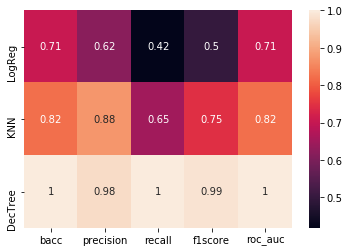

In [110]:
sb.heatmap(df_metrics, annot=True) 

# 8. Kesimpulan
## Dari Hasil perbandingan metrics di atas, dapat disimpulkan bahwa model terbaik dalam task ini adalah menggunakan model Decision Tree

<hr>
<hr>

# 9. Using "BEST MODEL" for Predicting Real Data

In [114]:
dftes = pd.read_csv('tes.csv', delimiter='\t')
dftes

,Name,Club,Country,Age,Height,Weight,Avg Points,Avg Rebounds
0,Andakara Prastawa Dyaksa,Pelita Jaya Bakrie,lintang Indonesia,24,190,90,7,6
1,Reggie Mononimbar,Pelita Jaya Bakrie,lintang Indonesia,21,185,86,6,3
2,Hardianus Lakudu,Satria Muda Pertamina Jakarta,lintang Indonesia,23,178,83,10,3
3,Kevin Yonas Sitorus,Satria Muda Pertamina Jakarta,lintang Indonesia,26,185,75,11,4
4,Arki Dikania Wisnu,Satria Muda Pertamina Jakarta,lintang Indonesia,20,183,80,5,2
5,Laurentius Steven Oei,Satria Muda Pertamina Jakarta,lintang Indonesia,21,191,85,4,10
6,Mei Joni,Stapac,lintang Indonesia,25,188,90,7,5
7,Vincent Rivaldi Kosasih,Stapac,lintang Indonesia,23,179,87,1,2
8,Hardian Wicaksono,Pacific Caesar Surabaya,lintang Indonesia,21,177,80,9,8
9,Brandon Jawato,Louvre Surabaya,lintang Indonesia,24,182,85,6,5


In [122]:
X = dftes.iloc[:, -5:]
X_ = scalerku.transform(X)

In [124]:
# y_LG = LG_model.predict(X_)
# y_KNN = KNN_model.predict(X_)
y_DT = DT_model.predict(X_)

# dftes['prediksi LogReg'] = y_LG
# dftes['prediksi KNN'] = y_KNN
dftes['prediksi DecTree'] = y_DT
dftes

,Name,Club,Country,Age,Height,Weight,Avg Points,Avg Rebounds,prediksi DecTree
0,Andakara Prastawa Dyaksa,Pelita Jaya Bakrie,lintang Indonesia,24,190,90,7,6,False
1,Reggie Mononimbar,Pelita Jaya Bakrie,lintang Indonesia,21,185,86,6,3,False
2,Hardianus Lakudu,Satria Muda Pertamina Jakarta,lintang Indonesia,23,178,83,10,3,False
3,Kevin Yonas Sitorus,Satria Muda Pertamina Jakarta,lintang Indonesia,26,185,75,11,4,False
4,Arki Dikania Wisnu,Satria Muda Pertamina Jakarta,lintang Indonesia,20,183,80,5,2,False
5,Laurentius Steven Oei,Satria Muda Pertamina Jakarta,lintang Indonesia,21,191,85,4,10,False
6,Mei Joni,Stapac,lintang Indonesia,25,188,90,7,5,False
7,Vincent Rivaldi Kosasih,Stapac,lintang Indonesia,23,179,87,1,2,False
8,Hardian Wicaksono,Pacific Caesar Surabaya,lintang Indonesia,21,177,80,9,8,False
9,Brandon Jawato,Louvre Surabaya,lintang Indonesia,24,182,85,6,5,False


Dengan menggunakan model terbaik dalam task ini, data yang diberikan memberikan kesimpulan seperti yang dapat dilihat pada dataframe kolom "prediksi DecTree" di atas. 
## Dapat kami disimpulkan bahwa dari data pemain muda Indonesia yang diberikan ini __semuanya belum layak untuk direkrut__